In [51]:
# 텐서플로로 케이민즈 구현하기
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets # 학습용 데이터
from sklearn.preprocessing import scale # 전처리 스케일 : z점수 스케일
from tensorflow.python.framework import ops # framework(훈련목적) platform(클라우드 서포트 자원)
ops.reset_default_graph() # 그래프 초기화가 안되면 반복시 에러
sess = tf.Session() # 네트워크 -> gpu 통제(없으면 cpu)
iris = datasets.load_iris() # 150 x 4, target 
num_pts = len(iris.data) # 행갯수 : 150
num_feats = len(iris.data[0]) #  열갯수 : 4 변수수 => feature
k=3 # 그룹수
generations = 25 # 세대 (FFNN : epochs)

In [52]:
val = [0,2,3]
val = tf.tile(val, [5])
print("홀일때", sess.run(val))
val = [[1,1,0], [2,2,0], [3,3,0]] # 2차원 3x3
val = tf.tile(val, [5,2]) # 타일깔듯이 배치 5스택 2배
print('2차원 일때\n',sess.run(val))

홀일때 [0 2 3 0 2 3 0 2 3 0 2 3 0 2 3]
2차원 일때
 [[1 1 0 1 1 0]
 [2 2 0 2 2 0]
 [3 3 0 3 3 0]
 [1 1 0 1 1 0]
 [2 2 0 2 2 0]
 [3 3 0 3 3 0]
 [1 1 0 1 1 0]
 [2 2 0 2 2 0]
 [3 3 0 3 3 0]
 [1 1 0 1 1 0]
 [2 2 0 2 2 0]
 [3 3 0 3 3 0]
 [1 1 0 1 1 0]
 [2 2 0 2 2 0]
 [3 3 0 3 3 0]]


In [53]:
input_vecs = [[1., 2.], [2., 1.], [-2., -1.]] # 3x2
print('차원확대:\n', sess.run(tf.expand_dims(input_vecs, 0)), end="\n\n") # 1x3x2

input_vecs = [[1., 2.], [2., 1.], [-2., -1.]] 
print('차원확대:\n', sess.run(tf.expand_dims(input_vecs, 1))) #열을 확대 # 3x1x2

차원확대:
 [[[ 1.  2.]
  [ 2.  1.]
  [-2. -1.]]]

차원확대:
 [[[ 1.  2.]]

 [[ 2.  1.]]

 [[-2. -1.]]]


In [ ]:
"""
데이터 다루기
    reshape, transpose(전치), tile, expand_dims(차원확대)
"""

In [54]:
# Variable : 변동이 있는 수치 저장 : 가중치
# 데이터 준비
data_points = tf.Variable(iris.data) # 150x4
cluster_labels = tf.Variable(tf.zeros([num_pts], dtype=tf.int64)) # 150개의 클러스터 번호
# 데이터 중에서 중심값 결정
# 1x12(4x3)
rand_starts = np.array([iris.data[np.random.choice(len(iris.data))] # 중심값 결정
                        for _ in range(k)]) # 3개의 그룹

centroids = tf.Variable(rand_starts) # 12

centroid_matrix = tf.reshape(tf.tile(centroids, [num_pts, 1]), # 12 150
                             [num_pts, k, num_feats]) # 150 3 4 # 한번더해서 확인
# 입력데이터 150x4 
# 150x4x3 centroid_matrix == point_matrix
point_matrix = tf.reshape(tf.tile(data_points, [1, k]), # 150x4 3
                          [num_pts, k, num_feats]) # 150 3 4

# 거리값 150x3
distances = tf.reduce_sum(tf.square(point_matrix - centroid_matrix), axis=2)

centroid_group = tf.argmin(distances, 1) #열방향

print(tf.square(point_matrix - centroid_matrix), '\n', distances, '\n', centroid_group)


Tensor("Square_1:0", shape=(150, 3, 4), dtype=float64) 
 Tensor("Sum:0", shape=(150, 3), dtype=float64) 
 Tensor("ArgMin:0", shape=(150,), dtype=int64)


In [55]:
def data_group_avg(group_ids, data):
    # 150x4 ( 벡터의 +연산은 요소별)
    sum_total = tf.unsorted_segment_sum(data, group_ids, 3) #그룹별로 합계 # 3x [x, x2, x3, x4]
    
    num_total = tf.unsorted_segment_sum(tf.ones_like(data), group_ids, 3) # 그룹별 갯수 카운트(1로 채워서) 3x [x, x, x, x]
    
    avg_by_group = sum_total/num_total # 중심값 계산
    return(avg_by_group)

means = data_group_avg(centroid_group, data_points)
update = tf.group(centroids.assign(means), cluster_labels.assign(centroid_group))
init = tf.global_variables_initializer()
sess.run(init)



In [56]:
for i in range(generations):
    print('세대 {}, 횟수{}.'.format(i, generations))
    _, centroid_group_count = sess.run([update, centroid_group])
    group_count = []
    for ix in range(k):
        group_count.append(np.sum(centroid_group_count==ix))
    print("그룹수 : {}".format(group_count))
[centers, assignments] = sess.run([centroids, cluster_labels])
    

세대 0, 횟수25.
그룹수 : [30, 20, 100]
세대 1, 횟수25.
그룹수 : [28, 24, 98]
세대 2, 횟수25.
그룹수 : [28, 25, 97]
세대 3, 횟수25.
그룹수 : [29, 24, 97]
세대 4, 횟수25.
그룹수 : [30, 24, 96]
세대 5, 횟수25.
그룹수 : [31, 23, 96]
세대 6, 횟수25.
그룹수 : [32, 22, 96]
세대 7, 횟수25.
그룹수 : [32, 22, 96]
세대 8, 횟수25.
그룹수 : [32, 22, 96]
세대 9, 횟수25.
그룹수 : [32, 22, 96]
세대 10, 횟수25.
그룹수 : [32, 22, 96]
세대 11, 횟수25.
그룹수 : [32, 22, 96]
세대 12, 횟수25.
그룹수 : [32, 22, 96]
세대 13, 횟수25.
그룹수 : [32, 22, 96]
세대 14, 횟수25.
그룹수 : [32, 22, 96]
세대 15, 횟수25.
그룹수 : [32, 22, 96]
세대 16, 횟수25.
그룹수 : [32, 22, 96]
세대 17, 횟수25.
그룹수 : [32, 22, 96]
세대 18, 횟수25.
그룹수 : [32, 22, 96]
세대 19, 횟수25.
그룹수 : [32, 22, 96]
세대 20, 횟수25.
그룹수 : [32, 22, 96]
세대 21, 횟수25.
그룹수 : [32, 22, 96]
세대 22, 횟수25.
그룹수 : [32, 22, 96]
세대 23, 횟수25.
그룹수 : [32, 22, 96]
세대 24, 횟수25.
그룹수 : [32, 22, 96]


In [45]:
sess.run(centroid_group)

array([1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

model을 생성하는 프레임워크다

[]
500
[([1, -1, 0, -1, 1, 0, 0, 0, -1], 2), ([0, 0, 0, 0, 0, -1, -1, 0, 1], 4), ([1, 0, 0, -1, -1, 0, 1, 0, -1], 5), ([1, 0, 0, 0, -1, 0, -1, 0, 0], 2), ([0, 0, 0, 0, -1, 0, 0, 0, 0], 6), ([0, 0, 0, 0, -1, 0, 0, 0, 0], 6), ([1, -1, 0, 0, 0, 0, -1, 0, 0], 4), ([0, -1, 1, 0, 1, -1, -1, 0, 0], 8), ([0, 0, 0, 0, -1, 0, 0, 0, 0], 0), ([0, 0, 0, 0, 0, 0, 0, 0, -1], 4), ([1, 1, -1, 0, -1, 0, 0, -1, 0], 6), ([1, 0, 0, 0, -1, 0, 0, -1, 0], 1), ([0, 0, -1, 0, 0, 0, 1, -1, 0], 4), ([0, -1, 0, 1, -1, -1, 0, 0, 1], 7), ([1, -1, 0, -1, -1, 1, 0, 0, 0], 7), ([-1, 0, 0, 0, 1, 0, 0, -1, 0], 8), ([0, 0, -1, 0, 1, 0, -1, 0, 0], 3), ([1, -1, -1, -1, 0, 0, 0, 1, 0], 8), ([0, 0, 0, 0, 0, -1, 0, 0, 0], 8), ([-1, 0, 0, 1, 1, 1, -1, 0, 0], 8), ([0, 0, 0, 0, -1, 0, -1, 0, 1], 2), ([0, 0, -1, 0, 1, 0, -1, 0, 0], 5), ([1, -1, -1, 0, 0, 0, 0, 0, 0], 3), ([1, 0, 0, -1, -1, 0, 1, 0, -1], 5), ([0, 0, 0, 0, -1, -1, 1, 0, 0], 3), ([0, -1, 0, 0, -1, 0, 0, 0, 1], 7), ([0, 0, -1, 0, 0, 0, 1, -1, 0], 4), ([1, 0, 0, 0, -1,

iteration 500 Loss: 2.1145272
iteration 1000 Loss: 1.6034638
iteration 1500 Loss: 1.1302797
iteration 2000 Loss: 1.2431221
iteration 2500 Loss: 1.2978119
iteration 3000 Loss: 1.1069996
iteration 3500 Loss: 1.0334057
iteration 4000 Loss: 1.0142336
iteration 4500 Loss: 0.9402411
iteration 5000 Loss: 0.95775115
iteration 5500 Loss: 0.85830694
iteration 6000 Loss: 0.75012755
iteration 6500 Loss: 0.78373015
iteration 7000 Loss: 0.8143978
iteration 7500 Loss: 0.8029512
iteration 8000 Loss: 0.7656395
iteration 8500 Loss: 0.710812
iteration 9000 Loss: 0.8156086
iteration 9500 Loss: 0.7143366


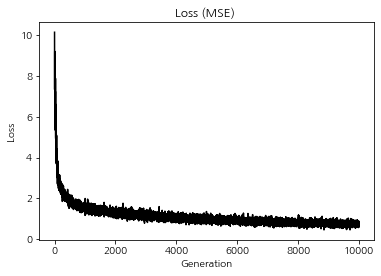

[6]
[6]


In [64]:
# email
# 텐서플로틱택토
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import random
import numpy as np
import random
from tensorflow.python.framework import ops
ops.reset_default_graph()

response = 6 # 결정된 번호
batch_size = 50 # 학습갯수

symmetry = ['rotate180', 'rotate90', 'rotate270', 'flip_v', 'flip_h'] 
# 데이터 증강(argmentation)
# : bootstrap, data_genenrator()

def print_board(board): # 판 출력
    symbols = ['O',' ','X']
    board_plus1 = [int(x) + 1 for x in board] # 공간 # ex) [컴, 사람, , , , , , ] 
    print(' ' + symbols[board_plus1[0]] + ' | ' + symbols[board_plus1[1]] + ' | ' + symbols[board_plus1[2]])
    print('___________')
    print(' ' + symbols[board_plus1[3]] + ' | ' + symbols[board_plus1[4]] + ' | ' + symbols[board_plus1[5]])
    print('___________')
    print(' ' + symbols[board_plus1[6]] + ' | ' + symbols[board_plus1[7]] + ' | ' + symbols[board_plus1[8]])

# 데이터 증강
# 0 1 2
# 3 4 5
# 6 7 8
def get_symmetry(board, response, transformation):
    if transformation == 'rotate180':
        new_response = 8 - response # 새로운 응답번호
        return(board[::-1], new_response)
    # 180도 회전시 8 - 원래인덱스 번호
    # 8 7 6
    # 5 4 3
    # 2 1 0
   
    elif transformation == 'rotate90':
        new_response = [6, 3, 0, 7, 4, 1, 8, 5, 2].index(response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return([value for item in tuple_board for value in item],
               new_response)
    # 90도 회전시
    # 6 3 0
    # 7 4 1
    # 8 5 2
   
    elif transformation == 'rotate270':
        new_response = [2, 5, 8, 1, 4, 7, 0, 3, 6].index(response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return([value for item in tuple_board for value in item],
               new_response)
    # 270도 회전시
    # 2 5 8
    # 1 4 7
    # 0 3 6
   
    elif transformation == 'flip_v': # 0 1 2 , 3 4 5 , 6 7 8
        new_response = [6, 7, 8, 3, 4, 5, 0, 1, 2].index(response)
        return(board[6:9] +  board[3:6] + board[0:3], new_response)
    # 수직으로 뒤집기
    # 6 7 8
    # 3 4 5
    # 0 1 2
       
    elif transformation == 'flip_h': 
        new_response = [2, 1, 0, 5, 4, 3, 8, 7, 6].index(response)
        new_board = board[::-1]
        return(new_board[6:9] +  new_board[3:6] + new_board[0:3],
               new_response)
    # 수평으로 뒤집기
    # 2 1 0
    # 5 4 3
    # 8 7 6
    
    else:
        raise ValueError('해당하는 경우가 없음')

 

def get_moves_from_csv(csv_file): # 훈련데이터 로딩
    moves = []
    with open(csv_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            moves.append(([int(x) for x in row[0:9]],int(row[9]))) # 독립변수, 종속변수
    return(moves)

def get_rand_move(moves, n=1, rand_transforms=2): # 데이터 증강 ( 랜덤 )
    (board, response) = random.choice(moves)
    possible_transforms = ['rotate90', 'rotate180', 'rotate270',
                           'flip_v', 'flip_h']
    for i in range(rand_transforms):
        random_transform = random.choice(possible_transforms) # 데이터 증강 방법 결정
        (board, response) = get_symmetry(board, response, random_transform) # get_symmetry
    return(board, response)


moves = get_moves_from_csv('tictactoe_moves.csv') # 기보
train_length = 500
train_set = []
print(train_set)

for t in range(train_length):
    train_set.append(get_rand_move(moves)) # 로딩한 데이터를 train_length번 증강
print(len(train_set))
print(train_set)
test_board = [-1, 0, 0, 1, -1, -1, 0, 0, 1] # 확인용 임의적으로 생성 1 user -1 com
train_set = [x for x in train_set if x[0] != test_board]
print(train_set)


def init_weights(shape):
    return(tf.Variable(tf.random_normal(shape)))

# 50x9 9x81 81x9 => 가중치 연산후 50x9 
def model(X, A1, A2, bias1, bias2):
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, A1), bias1))
    layer2 = tf.add(tf.matmul(layer1, A2), bias2)
    return(layer2) # 모델이 결정한 값

# 데이터입력
X = tf.placeholder(dtype=tf.float32, shape=[None, 9]) # 독립변수
Y = tf.placeholder(dtype=tf.int32, shape=[None]) # 종속변수

A1 = init_weights([9, 81]) # 특징확장 81
bias1 = init_weights([81])  
A2 = init_weights([81, 9]) # 확장후 -> 선택범위로 가중치 연산
bias2 = init_weights([9])
model_output = model(X, A1, A2, bias1, bias2) # 분산값처럼 수치결과 => cross_entropy 


loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits( # cross_entropy
    logits=model_output, labels=Y)) # 예측값, 실제값
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss) # 
prediction = tf.argmax(model_output, 1) # 예측값
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# 학습 과정
loss_vec = [] # 로스값을 저장
for i in range(10000):
    
    rand_indices = np.random.choice(range(len(train_set)), batch_size, # 랜덤으로 50개 데이터를 훈련세트에서 받아옴
                                    replace=False) # 중복허용여부
    batch_data = [train_set[i] for i in rand_indices] # 나온 50개 데이터
        
    x_input = [x[0] for x in batch_data] # 독립변수 50개 결정
    y_target = np.array([y[1] for y in batch_data]) # 종속변수 50개 결정
    #데이터를 2차원에 입력
    
    sess.run(train_step, feed_dict={X: x_input, Y: y_target})   
    temp_loss = sess.run(loss, feed_dict={X: x_input, Y: y_target})
    loss_vec.append(temp_loss)
    if i%500==0:
        print('iteration ' + str(i) + ' Loss: ' + str(temp_loss))


plt.plot(loss_vec, 'k-', label='Loss')
plt.title('Loss (MSE) ')
plt.xlabel('Generation')
plt.ylabel('Loss') # 손실의 변화 확인
plt.show()
test_boards = [test_board]
feed_dict = {X: test_boards}
logits = sess.run(model_output, feed_dict=feed_dict)
predictions = sess.run(prediction, feed_dict=feed_dict)
print(predictions) # 예측 결과

 
# 승패 결정
test_boards = [test_board]
feed_dict = {X: test_boards}
logits = sess.run(model_output, feed_dict=feed_dict)
predictions = sess.run(prediction, feed_dict=feed_dict) # 예측값 결정
print(predictions)

def check(board):
    wins = [[0,1,2], [3,4,5], [6,7,8], [0,3,6], [1,4,7], [2,5,8],
            [0,4,8], [2,4,6]] # 승리 상황 : 3개 나열되면...
    
    for i in range(len(wins)):
        if board[wins[i][0]]==board[wins[i][1]]==board[wins[i][2]]==1.: # 유저-승
            return(1)
        elif board[wins[i][0]]==board[wins[i][1]]==board[wins[i][2]]==-1.: # 컴-승
            return(-1)
    return(0)



In [63]:

game_tracker = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
win_logical = False
num_moves = 0      
# 턴방식 게임
while not win_logical:
    player_index = input('이동하고 싶은 인덱스를 입력하시요 (0-8): ') # 
    num_moves += 1 # 선택횟수 저장
    game_tracker[int(player_index)] = 1.#사람
    
    #임시적으로 가능한 인덱스가 결정 # 경우의 수가 많다
    [potential_moves] = sess.run(model_output,
                                 feed_dict={X: [game_tracker]})

    # 0번인 경우만 선택이 가능
    allowed_moves = [ix for ix,x in enumerate(game_tracker) if x==0.0] # 말판에서 결정
    
    #이동가능한 위치확인후 이동번호 결정
    model_move = np.argmax([x if ix in allowed_moves else -999.0 # 선택에서 제외
                            for ix,x in enumerate(potential_moves)]) 
    game_tracker[int(model_move)] = -1. #컴
    print('모델이 이동하였습니다.')
    print_board(game_tracker)
    if check(game_tracker)==1 or num_moves>=20:
        print('게임 종료! 승리하셨습니다.  ')
        win_logical = True
    elif check(game_tracker)== -1:
        print('게임 종료 ! 게임에 지셨습니다. !')
        win_logical = True

이동하고 싶은 인덱스를 입력하시요 (0-8): 4
모델이 이동하였습니다.
   |   |  
___________
   | X |  
___________
   |   | O
이동하고 싶은 인덱스를 입력하시요 (0-8): 1
모델이 이동하였습니다.
 O | X |  
___________
   | X |  
___________
   |   | O
이동하고 싶은 인덱스를 입력하시요 (0-8): 7
모델이 이동하였습니다.
 O | X |  
___________
 O | X |  
___________
   | X | O
게임 종료! 승리하셨습니다.  


In [ ]:
# 오전 종료 ===========================================================================================================================================================================================================

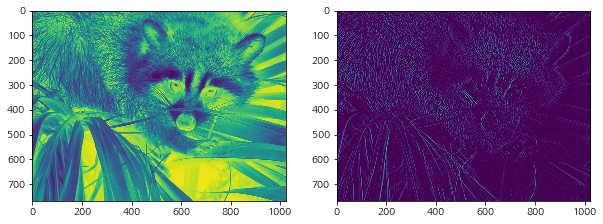

In [67]:
# CNN
%matplotlib inline
import scipy as sp
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

# 학습용 이미지
img = 255 - sp.misc.face(gray=True).astype(float) # 역컬러로 표현하기 위해서

k = np.zeros((2,2))
# 0 0
# 0 0

k[:,0] = 1; k[:,1] = -1
# 값의 경계선을 찾는 필터
# 1 -1
# 1 -1

# maximum 사용 논리 : 이미지는 -가 없음
img2 = np.maximum(0, sp.ndimage.filters.convolve(img, k)) # 텐서플로없는 convolution(다양한곳에 사용 ex)정보통신 노이즈 추출)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img)
plt.grid(False)
plt.subplot(122)
plt.imshow(img2)
plt.grid(False)
plt.show()

In [76]:
# 필터만들기
import tensorflow as tf
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    
def plot_color_image(image):
    plt.imshow(image.astype(np.uint8), interpolation="nearest")
    plt.axis('off')

In [ ]:
"""
# filter 형태
- filter는 4차원
- 필터 행, 열, 채널, 장수, 필터의 장수
shape=(7, 7, 1, 2)
"""

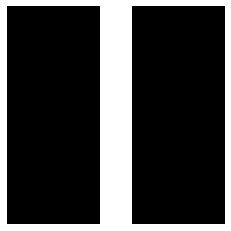

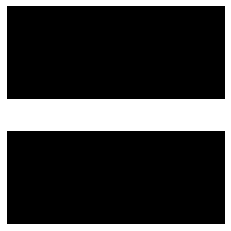

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


In [77]:
import numpy as np
import matplotlib.pyplot as plt
# 채널은 컬러 
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:,3,0,0] = 1
fmap[3,:,0,1] = 1
fmap[:,:,0,0]
plot_image(fmap[:,:,0,0])
plt.show()
plot_image(fmap[:,:,0,1])
plt.show()
print(fmap[:,:,0,0])

In [80]:
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')
flower = load_sample_image('flower.jpg')
image = china[150:220, 130:250]
height, width, channels = image.shape
print(image.shape) # (70, 120, 3) # 채널 last 로 값이 입력 # 컬러가 3 RGB

image_grayscale = image.mean(axis=2).astype(np.float32)# RGB -> grayscale => 70x120
images = image_grayscale.reshape(1, height, width, 1) # 이미지의 입력형식

(70, 120, 3)


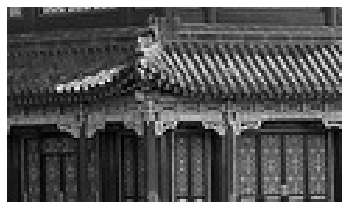

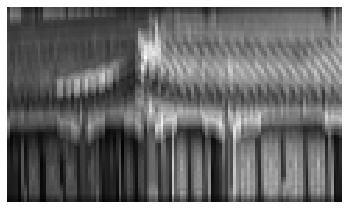

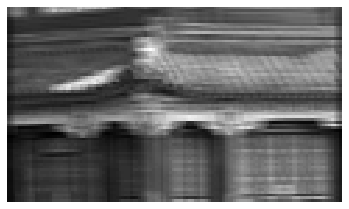

In [84]:
# 1, height, width, 1 (배치 사이즈, 행, 열 ,채널)
# 형식일치
from tensorflow.python.framework import ops
ops.reset_default_graph()
#
X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)

# 출력차수 == 입력차수와 동일하게 하라 same , valid : padding하지말고 정석으로 계산하라
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=False)

# 필터의 개수만큼 이미지가 생성 (이미지 특징을 추출)
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})
plot_image(images[0,:,:,0])
plt.show()
plot_image(output[0,:,:,0])
plt.show()
plot_image(output[0,:,:,1])
plt.show()

In [95]:
# dataset = np.array([china, flower], dtype=np.float32)
# batch_size, height, width, channels = dataset.shape
# print(batch_size, height, width, channels)
# print(output.shape)

# ops.reset_default_graph()
# dataset = dataset.mean(axis=2).astype(np.float32)
# X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
# feature_maps = tf.constant(fmap)

# convolution = tf.nn.conv2d(X, feature_maps, strides=[1,2,2,1], padding='SAME')
# with tf.Session() as sess:
#     output = sess.run(convolution, feed_dict={X:dataset})
    
# plt.imshow(output[0,:,:,1], cmap='gray')
# plt.show()
# 강사님 코딩 잘안됨 ▼ 걍 밑에 걸로 실행

2 427 640 3
(2, 214, 320, 2)


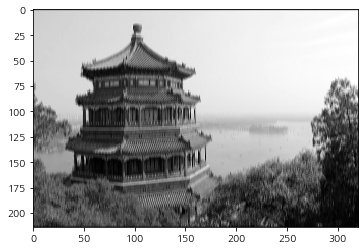

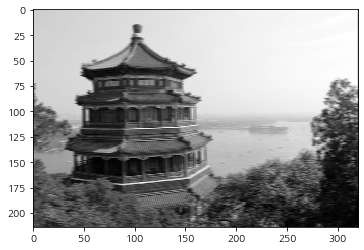

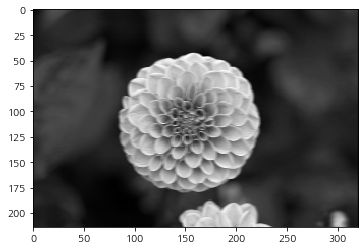

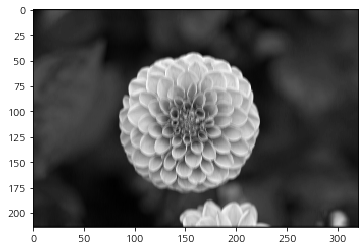

(2, 214, 320, 2)


In [99]:
# email
import numpy as np
from sklearn.datasets import load_sample_image
import tensorflow as tf

china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32) # 이미지 묶음
batch_size, height, width, channels = dataset.shape # channel last
print(batch_size, height, width, channels)
print(output.shape)

# 7x7x3x2 : 마지막 2는 장수
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) 
filters[:, 3, :, 0] = 1 # 세로
filters[3, :, :, 1] = 1 # 가로


X = tf.placeholder(tf.float32, shape=(None, height, width, channels))

# stride가 두번씩 건너뛰어서 이미지 사이즈가 반으로 줄어듬
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")
with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

# 이미지 2장 * 필터 2장 = 4장의 특징을 가진 이미지(특징맵) 생성
plt.imshow(output[0, :, :, 0], cmap="gray")
plt.show()
plt.imshow(output[0, :, :, 1], cmap="gray")
plt.show()
plt.imshow(output[1, :, :, 1], cmap="gray")
plt.show()
plt.imshow(output[1, :, :, 0], cmap="gray")
plt.show()
print(output.shape) 

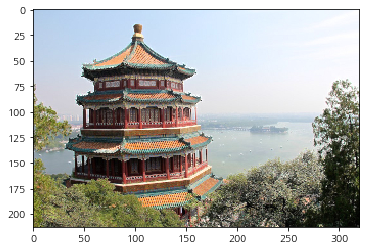

In [101]:
# pooling
# 풀링으로 이미지 축소
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))

# 계산한대로 줄어듬
# 행2 x 열2 : 4개를 1개로 가장큰값으로 풀링 ( max, avg)
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

with tf.Session() as sess:
     output = sess.run(max_pool, feed_dict={X: dataset})
        
plt.imshow(output[0].astype(np.uint8))
plt.show()  

In [102]:
#email
from __future__ import division, print_function, absolute_import

import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

# 신경망에서 타겟은 원핫인코딩 되어야함 (신경망에 0, 1 아니면 의미가 없다)
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True) # 원핫인코딩하면.. 00000000000 중에 하나가 1

learning_rate = 0.001
num_steps = 500 # epoch
batch_size = 128 # mini batch : 배치학습 : 전체데이터 / batch_size => 전부학습에 참여(분할해서 학습)
display_step = 10

num_input = 784 # 데이터 입력사이즈 미지지 :28x28
num_classes = 10 # 범주형 데이터인 target이 10개
dropout = 0.75 # 과적합방지( =규제 ) 신경망이 정교하여 계산식의 일부를 계산하지않아도 문제없다

X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probabilit


def conv2d(x, W, b, strides=1): # convolution의 가중치는 필터
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) # activation 함수 렐루: 0 ~ ∞


def maxpool2d(x, k=2): # 4 -> 1 줄임 풀링
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

def conv_net(x, weights, biases, dropout): # convolution 연산 코드
    
    x = tf.reshape(x, shape=[-1, 28, 28, 1]) # 128x28x28x1
    # 이미지 형식에서 특징 추출 # -1이면 계산한 나머지 
    # 동일사이즈로 출력
    # 훈련될때 입력되는 데이터 사이즈 128x28x28x1
    
    
    conv1 = conv2d(x, weights['wc1'], biases['bc1']) # [5, 5, 1, 32] # 5x5x1의 필터가 32장 :필터의 장수(랜덤 초기화)
    #128x28x28x32
    conv1 = maxpool2d(conv1, k=2) # 사이즈 반으로 # 128x14x14x32
    
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2']) # [5, 5, 32, 64] 
    #128x14x14x64
    conv2 = maxpool2d(conv2, k=2) # 사이즈 반으로 # 128x7x7x64
        
    # fully-connected
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]]) # 결과를 reshape => [128, 7x7x64]
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1']) # [7x7x64, 1024(특징을 1024로 하자)] => 128 x 1024
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout) # 계산증가 일부회로 계산 생략 : 규제
    
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out']) # [1024, num_classes] 
    # 128 x 1024, 1024 x num_classes => 128 x num_class
    
    return out # 최종 사이즈 : 이미지 사이즈(128) * 10(num_classes)

weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    'out': tf.Variable(tf.random_normal([1024, num_classes])) # 특징의 마지막
}

biases = {  # 가중치 연산후 최종사이즈와 동일
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# FFNN (feed forward neural network)
logits = conv_net(X, weights, biases, keep_prob) # minibatch 사이즈 * 10
prediction = tf.nn.softmax(logits) # 확률값으로 변경 => 값을 전부합치면? 1 (전체확률값)

#분류에서의 비용함수
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y)) # 비용함수로 변경

# Adam Op = RMSProp( 학습률을 상태에 따라 조절 ) + momentum ( 관성 ) + 미분 ( 결과값을 저장 )
# 가중치를 조절
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)# 학습 완료

# 신경망은 원핫인코딩 
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1)) # minibatch 사이즈만큼 0100(원핫인코딩값)나옴
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32)) # 정확도
# /망구성 종료 #

# 학습
init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)

    for step in range(1, num_steps+1): # epoch만큼
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        # placeholder로 feeding
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            print("단계 " + str(step) + ",  Loss= " +
                  "{:.4f}".format(loss) + ",  Accuracy= " +
                  "{:.3f}".format(acc))

    print("최적화 종료")

    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                      Y: mnist.test.labels[:256],
                                      keep_prob: 1.0})) # 다계산하라

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


In [ ]:
"""
CNN ( convoultion neural network ) - keras에서 application으로 만들어진것을 쓸것(transfer learning)
- imagenet에서 1등한 model
- VGG(영상), ResNet(영상), inceptionV3, efficientNet
    - VGG - 3x3 fillter 를 이용해서 고속
    - ResNet - 이전값을 다시한번 고려해서 기울기 소실 문제 개선
- VGG, ResNet : 동영상 처리 -> 고속
- inceptionV3 - width로 확장
- efficientNet
    - fillter size
    - layer 깊게
    - image 해상도를 높이는 방법
    - 위 3가지를 조화로운 방법으로 개선
transfer learning
- 하나의 도메인에서 학습된 가중치를 다른 문제 전이해서 사용
    - 훈련된 가중치를 기반으로 새롭게 학습
    - 학습 속도가 빨라짐
    - 데이터 부족문제 해결
    - 목표 : 더 정교하게 더 빠르게
image augmentaion
    - 이미지 증강
    - rotate, flip, clip - 데이터를 변형
    - 하드에서 이미지를 일정한 사이즈로 자동으로 로딩하는것을 지원

CNN이 어떻게 돌아가는지 이해하는게 오늘 실습목표( 더쉽게 사용하는것이 존재 )
""" 